## Postprocessing - Reject Option Classification - Adult Model
- for 'sex' and 'race'

In [1]:
import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), "../.."))
sys.path.insert(0, project_root)

import pandas as pd
from src.data_loading import load_adult_sex, load_adult_race
from src.modeling import reject_option_classification_train_and_predict
from src.metrics import compute_metrics, compare_viz_metrics_2x3, save_agg_metrics, save_raw_metrics
from sklearn.model_selection import StratifiedShuffleSplit

%matplotlib inline
import matplotlib
matplotlib.use('module://matplotlib_inline.backend_inline')


/opt/anaconda3/lib/python3.11/site-packages/inFairness/utils/ndcg.py:37: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.vmap` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.vmap` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  vect_normalized_discounted_cumulative_gain = vmap(
/opt/anaconda3/lib/python3.11/site-packages/inFairness/utils/ndcg.py:48: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.vmap` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.vmap` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  monte_carlo_vect_ndcg = vmap(vect_normalized_di

In [2]:
dataset_name = 'adult'
mitigation_name   = 'reject option classification'
pipeline_stage    = 'postprocessing'  
out_dir_plots    = '../../reports/plots_adult'

In [3]:

METRICS = ['accuracy', 'f1_score', 'SPD', 'DI', 'EOD', 'AOD']
AGG_OUT_PATH = '../../reports/agg_metrics.csv'
RAW_OUT_PATH = '../../reports/raw_metrics.csv'
KEYS = ['Dataset', 'Sensitive Attribute', 'Mitigation']

In [4]:
baseline_race_agg = pd.read_csv('../../reports/baseline_agg/adult_race_metrics_agg.csv', index_col=0)
baseline_sex_agg = pd.read_csv('../../reports/baseline_agg/adult_sex_metrics_agg.csv', index_col=0)

In [5]:
def save_agg_metrics_single(dataset_name, mitigation_name,
                            attr_name, agg_df, pipeline_stage):
    mean = agg_df.loc['mean', METRICS]
    std  = agg_df.loc['std', METRICS]
    row = {
        'Dataset': dataset_name,
        'Sensitive Attribute': attr_name,
        'Pipeline': pipeline_stage,
        'Mitigation': mitigation_name
    }
    for m in METRICS:
        row[m]         = mean[m]
        row[f'{m}_std'] = std[m]
    
    new_df = pd.DataFrame([row])

    if os.path.exists(AGG_OUT_PATH):
        existing = pd.read_csv(AGG_OUT_PATH)
        mask = existing.set_index(KEYS).index.isin(new_df.set_index(KEYS).index)
        existing = existing[~mask]
        final = pd.concat([existing, new_df], ignore_index=True)
    else:
        final = new_df

    final.to_csv(AGG_OUT_PATH, index=False)


In [6]:
def save_raw_metrics_single(dataset_name, mitigation_name,
                            attr_name, raw_df, pipeline_stage):
    tmp = raw_df.reset_index(drop=True).copy()
    tmp['Dataset'] = dataset_name
    tmp['Sensitive Attribute'] = attr_name
    tmp['Pipeline'] = pipeline_stage
    tmp['Mitigation'] = mitigation_name

    front = KEYS
    cols = front + [c for c in tmp.columns if c not in front]
    tmp = tmp[cols]

    if os.path.exists(RAW_OUT_PATH):
        existing = pd.read_csv(RAW_OUT_PATH)
        mask = existing.set_index(KEYS).index.isin(tmp.set_index(KEYS).index)
        existing = existing[~mask]
        final = pd.concat([existing, tmp], ignore_index=True)
    else:
        final = tmp

    final.to_csv(RAW_OUT_PATH, index=False)


--------------------------------------------------------------------------------------------------------------------------------------

## default Reject Option Classification, sex

In [11]:
# 1) Load data
protected          = 'sex'
privileged_value   = 1.0
unprivileged_value = 0.0

ds, df = load_adult_sex()  
feature_cols = [c for c in df.columns if c not in ('label', protected)]

# 2) Run experiment and evaluate
sss = StratifiedShuffleSplit(n_splits=25, test_size=0.2, random_state=42)

results = []
for train_idx, test_idx in sss.split(df, df['label']):
    test_df, y_test, y_pred_post = reject_option_classification_train_and_predict(
        df,
        train_idx,
        test_idx,
        feature_cols,
        protected,
        privileged_value,
        unprivileged_value
    )

    m = compute_metrics(
        test_df, y_test, y_pred_post,
        protected, privileged_value, unprivileged_value
    )
    results.append(m)

# 3) Aggregate results
adult_sex_metrics     = pd.DataFrame(results)
adult_sex_metrics_agg = adult_sex_metrics.agg(['mean', 'std'])
print(adult_sex_metrics_agg) 

      accuracy  f1_score       SPD        DI       EOD       AOD
mean  0.784658  0.636955 -0.043159  0.882468  0.160710  0.106829
std   0.011885  0.007262  0.009895  0.026787  0.019467  0.009422


/var/folders/pr/f4jl4tln3yn9fd_1yjrwwkp40000gn/T/ipykernel_7565/366461395.py:6: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


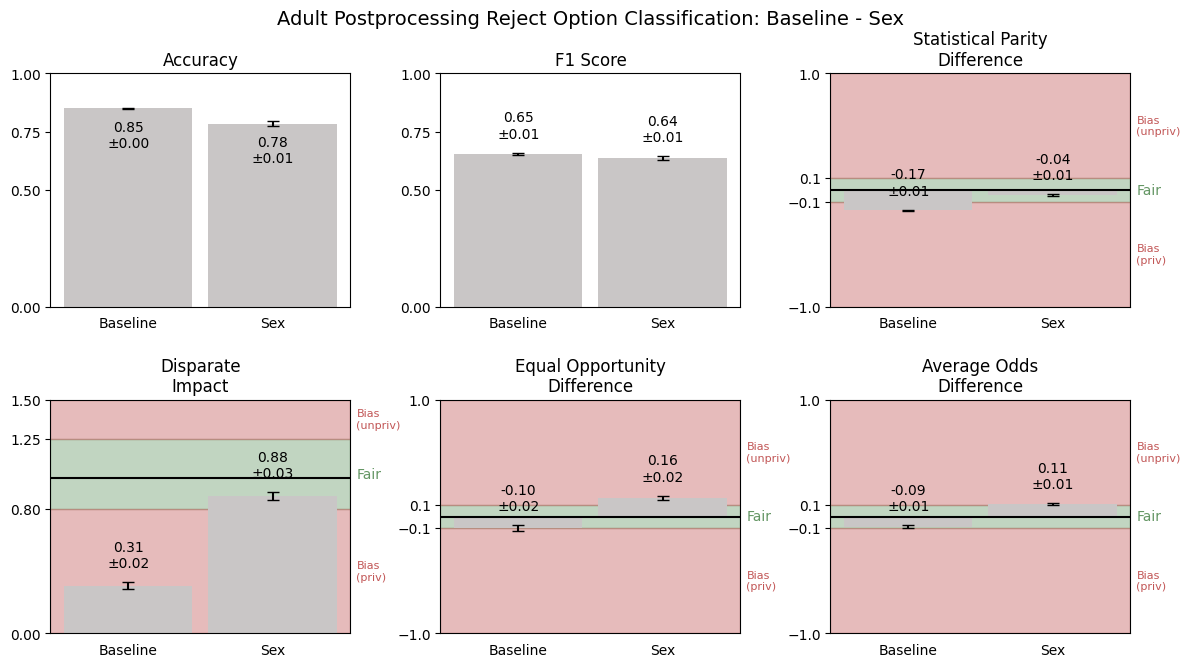

In [12]:
plot_title = 'Adult Postprocessing Reject Option Classification: Baseline - Sex'
fig = compare_viz_metrics_2x3(baseline_sex_agg, adult_sex_metrics_agg, 'Baseline', 'Sex', plot_title)
fname    = plot_title.replace(' ', '_').replace('(', '').replace(')', '')
out_path = os.path.join(out_dir_plots, f'{fname}.png')
fig.savefig(out_path)
fig.show()

In [13]:
save_agg_metrics_single(
    dataset_name     = 'adult',
    mitigation_name  = 'reject option classification',
    attr_name        = 'sex',
    agg_df           = adult_sex_metrics_agg,
    pipeline_stage   = 'postprocessing'
)

save_raw_metrics_single(
    dataset_name     = 'adult',
    mitigation_name  = 'reject option classification',
    attr_name        = 'sex',
    raw_df           = adult_sex_metrics,
    pipeline_stage   = 'postprocessing'
)


## default  Reject Option Classification, race

In [7]:
# 1) Load data
protected          = 'race'
privileged_value   = 1.0
unprivileged_value = 0.0

ds, df = load_adult_race()  
feature_cols = [c for c in df.columns if c not in ('label', protected)]

# 2) Run experiment and evaluate
sss = StratifiedShuffleSplit(n_splits=25, test_size=0.2, random_state=42)

results = []
for train_idx, test_idx in sss.split(df, df['label']):
    test_df, y_test, y_pred_post = reject_option_classification_train_and_predict(
        df,
        train_idx,
        test_idx,
        feature_cols,
        protected,
        privileged_value,
        unprivileged_value
    )

    m = compute_metrics(
        test_df, y_test, y_pred_post,
        protected, privileged_value, unprivileged_value
    )
    results.append(m)

# 3) Aggregate results
adult_race_metrics     = pd.DataFrame(results)
adult_race_metrics_agg = adult_race_metrics.agg(['mean', 'std'])
print(adult_race_metrics_agg)

      accuracy  f1_score       SPD        DI       EOD       AOD
mean  0.795746  0.666406 -0.045593  0.879665  0.070399  0.039139
std   0.006708  0.006408  0.012405  0.033079  0.020749  0.013287


/var/folders/pr/f4jl4tln3yn9fd_1yjrwwkp40000gn/T/ipykernel_16467/2411133641.py:6: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


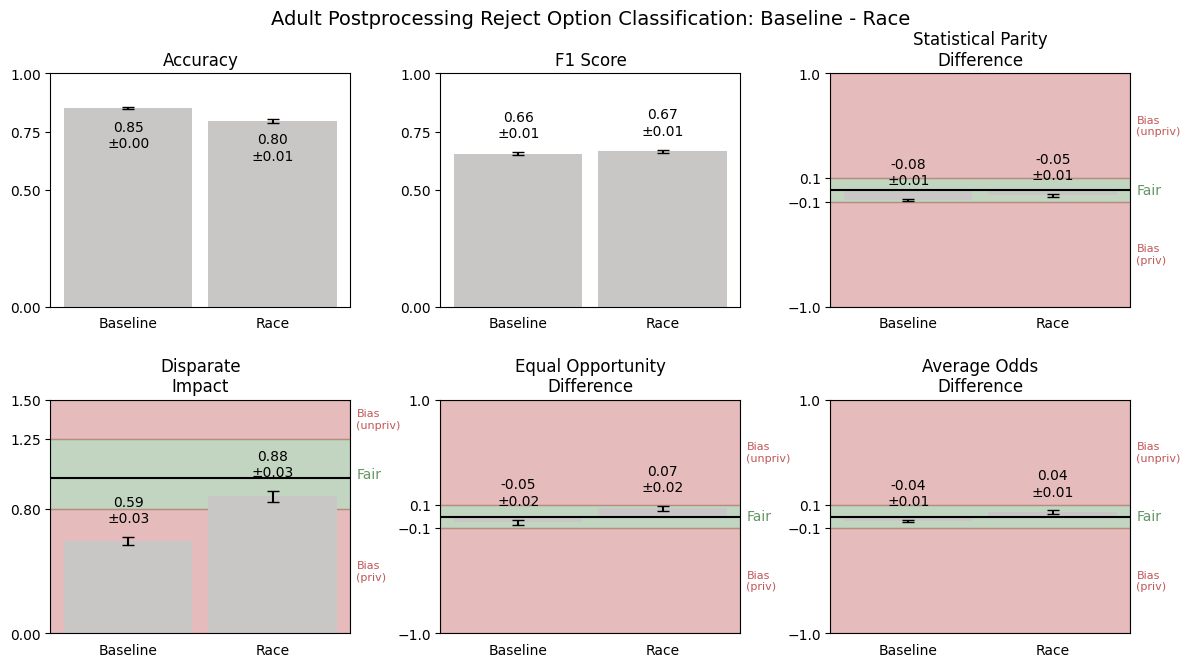

In [8]:
plot_title = 'Adult Postprocessing Reject Option Classification: Baseline - Race'
fig = compare_viz_metrics_2x3(baseline_race_agg, adult_race_metrics_agg, 'Baseline', 'Race', plot_title)
fname    = plot_title.replace(' ', '_').replace('(', '').replace(')', '')
out_path = os.path.join(out_dir_plots, f'{fname}.png')
fig.savefig(out_path)
fig.show()

In [9]:
save_agg_metrics_single(
    dataset_name     = 'adult',
    mitigation_name  = 'reject option classification',
    attr_name        = 'race',
    agg_df           = adult_race_metrics_agg,
    pipeline_stage   = 'postprocessing'
)

save_raw_metrics_single(
    dataset_name     = 'adult',
    mitigation_name  = 'reject option classification',
    attr_name        = 'race',
    raw_df           = adult_race_metrics,
    pipeline_stage   = 'postprocessing'
)


# -------------

In [ ]:
# 1) Save the aggregated metrics 
save_agg_metrics(
    dataset_name      = dataset_name,
    mitigation_name   = mitigation_name,
    race_agg_df       = adult_race_metrics_agg,
    sex_agg_df        = adult_sex_metrics_agg,
    pipeline_stage    = pipeline_stage   
)

# 2) Save the raw metrics
save_raw_metrics(
    dataset_name      = dataset_name,
    mitigation_name   = mitigation_name,
    race_raw_df       = adult_race_metrics,
    sex_raw_df        = adult_sex_metrics,
    pipeline_stage    = pipeline_stage
)